In [ ]:
import pandas as pd
import json
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import biotite.structure as bs
import biotite.structure.io.pdb as pdb
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import biotite.structure.io as bsio
from multiprocessing import Pool
from biotite.sequence import ProteinSequence

threetoone = ProteinSequence.convert_letter_3to1

SABDAB_DIR = "sabdab"

chains_df = pd.read_parquet("preprocessed_data/sabdab_2025-05-06-paired_chains.parquet")

# Process sampled sequences for Ibex folding

In [ ]:
temperatures = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
sampled_sequences_dir = "sample_cdrs/igbert"
for temp in temperatures:
    temp_dfs = []
    for loop_type in ['L1', 'L2', 'L3', 'H1', 'H2', 'H3']:
        sampled_sequences = f"sample_cdrs/igbert/sampled_sequences/temp_{temp}/{loop_type}_sample.csv"
        df = pd.read_csv(sampled_sequences)
        seq_col = 'fv_heavy' if loop_type.startswith('H') else 'fv_light'
        df.rename(columns={'sequence': seq_col}, inplace=True)
        other_chain = 'H' if loop_type.startswith('L') else 'L'
        other_seq_col = 'fv_light' if loop_type.startswith('H') else 'fv_heavy'
        df = df.merge(chains_df[chains_df['chain_id']==other_chain][['ab_fname', 'sequence']].rename(columns={'sequence': other_seq_col}), left_on='seqid', right_on='ab_fname', how='left')
        df['id'] = df['seqid'].str.replace('.pdb','') + f"_{loop_type}_" + df['sample_id'].astype(str)
        temp_dfs.append(df[['id', 'fv_heavy', 'fv_light']])
    temp_df = pd.concat(temp_dfs, ignore_index=True)
    temp_df.to_csv(f"sample_cdrs/igbert/output/temp_{temp}_ibex.csv", index=False)


# Analyse scRMSD results
First run run_rmsd_calculation.py

In [ ]:
results_df = pd.read_csv('sample_cdrs/rmsd_results.csv')
results_df['edit_distance'] = results_df.apply(lambda row: sum(c1 != c2 for c1, c2 in zip(row['sabdab_seq'], row['sampled_seq'])), axis=1)
results_df['sequence_identity'] = results_df.apply(lambda row: 1 - (row['edit_distance'] / len(row['sabdab_seq'])), axis=1)

In [4]:
results_df.value_counts('model')

model
abmpnn          21000
antifold        21000
proteinmpnn     21000
igbert_igloo    20919
igbert          20896
igloolm         19476
Name: count, dtype: int64

In [5]:
bins = np.arange(0.0, 1.0, 0.05)
results_df['sequence_identity_category'] = pd.cut(
    results_df['sequence_identity'],
    bins=bins,
    labels=[np.mean([bins[i], bins[i+1]]) for i in range(len(bins)-1)],
    include_lowest=True,
)

# Plot results
IglooALM outperforms AntiFold and AbMPNN, comapred to ProteinMPNN it achieves comparable results. However, ProteinMPNN struggles to generate sequences close to the original seed sequence (as seen in the top sequence diversity plot).

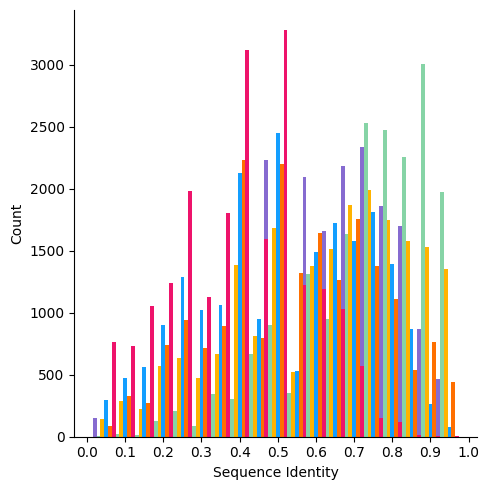

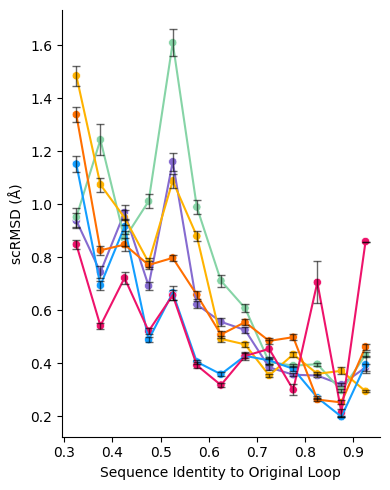

In [14]:
color_palette = {
    'abmpnn': '#866BD0', 
    'antifold': '#86D4A6',
    'igbert_igloo': '#139EFF',
    'proteinmpnn': "#EE136B",
    'igbert': '#FFB300',
    'igloolm': '#FF6F00',
}

plot_df = results_df.groupby(['model', 'sequence_identity_category'], observed=False).agg(
    mean_rmsd=('rmsd', 'mean'), se_rmsd=('rmsd', 'sem'), std_rmsd=('rmsd', 'std'), count=('rmsd', 'count')
).reset_index()
plot_df['sequence_identity_category'] = plot_df['sequence_identity_category'].astype(float)

plt.figure(figsize=(5,5))
for i, model in enumerate(plot_df['model'].unique()):
    model_data = plot_df[plot_df['model'] == model]
    # Apply horizontal offset if overlapping
    offset = (i - 0.5) * 0.01  # small offset to separate bars slightly
    plt.bar(
        model_data['sequence_identity_category'] + offset,
        model_data['count'],
        width=0.01,
        label=model,
        color=color_palette[model]
    )

# Now the x-axis is truly continuous
plt.xlabel("Sequence Identity")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(0.0, 1.01, 0.1))
plt.legend().remove()
plt.savefig("figures/sequence_identity_with_protein_mpnn.svg", format='svg', bbox_inches='tight')
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


plot_df = plot_df[(plot_df['sequence_identity_category'] >= 0.325) & (plot_df['sequence_identity_category'] <= 0.925)] # & (plot_df['count'] > 10)
plt.figure(figsize=(4,5))
sns.scatterplot(
    data=plot_df,
    x='sequence_identity_category',
    y='mean_rmsd',
    hue='model',
    palette=color_palette,
)
sns.lineplot(
    data=plot_df,
    x='sequence_identity_category',
    y='mean_rmsd',
    hue='model',
    palette=color_palette,
)
sns.despine()
for model in plot_df['model'].unique():
    model_data = plot_df[plot_df['model'] == model]
    plt.errorbar(
        x=model_data['sequence_identity_category'].astype(float),
        y=model_data['mean_rmsd'],
        yerr=model_data['se_rmsd'],
        fmt='none',  # no marker
        capsize=3,
        elinewidth=1,
        alpha=0.6,
        color='black',
    )
plt.xlabel("Sequence Identity to Original Loop")
plt.ylabel("scRMSD (Å)")
plt.tight_layout()
plt.legend().remove()
plt.savefig("figures/scRMSD_with_protein_mpnn.svg", format='svg', bbox_inches='tight')
plt.show()

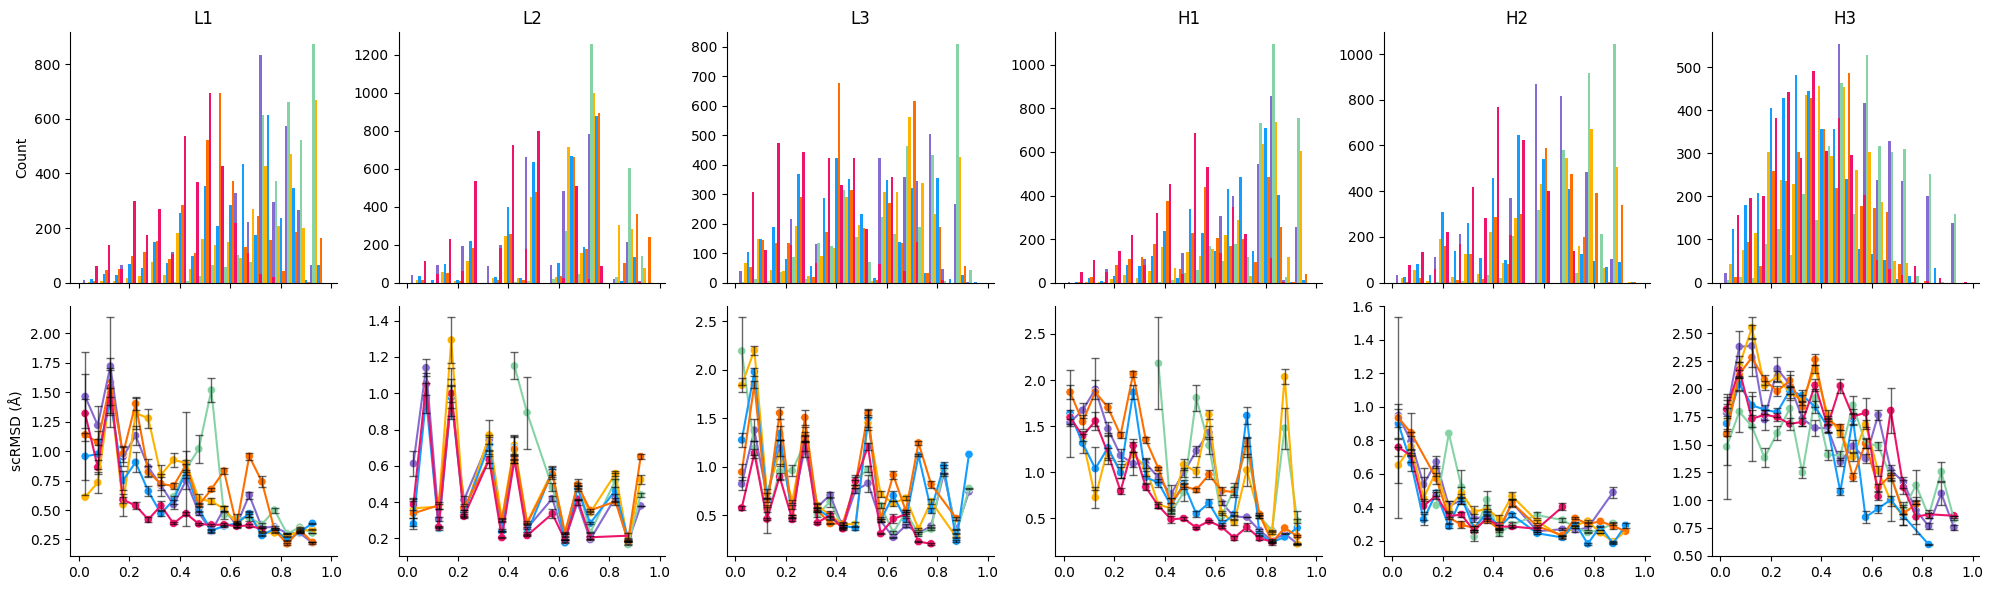

In [15]:
color_palette = {
    'abmpnn': '#866BD0', 
    'antifold': '#86D4A6',
    'igbert_igloo': '#139EFF',
    'proteinmpnn': "#EE136B",
    'igbert': '#FFB300',
    'igloolm': '#FF6F00',
}

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,6), sharex=True)

for loop_i, loop_type in enumerate(['L1', 'L2', 'L3', 'H1', 'H2', 'H3']):
    plot_df = results_df[(results_df['loop_type'] == f'CDR{loop_type[1]}') & (results_df['chain_id'] == loop_type[0])].groupby(['model', 'sequence_identity_category'], observed=False).agg(
        mean_rmsd=('rmsd', 'mean'), se_rmsd=('rmsd', 'sem'), std_rmsd=('rmsd', 'std'), count=('rmsd', 'count')
    ).reset_index()
    plot_df['sequence_identity_category'] = plot_df['sequence_identity_category'].astype(float)

    for i, model in enumerate(plot_df['model'].unique()):
        model_data = plot_df[plot_df['model'] == model]
        # Apply horizontal offset if overlapping
        offset = (i - 0.5) * 0.01  # small offset to separate bars slightly
        axes[0,loop_i].bar(
            model_data['sequence_identity_category'] + offset,
            model_data['count'],
            width=0.01,
            label=model,
            color=color_palette[model]
        )

    # Now the x-axis is truly continuous
    if loop_i == 0:
        axes[0,loop_i].set_ylabel("Count")
    axes[0,loop_i].set_title(loop_type)
    axes[0,loop_i].set_xticks(ticks=np.arange(0.0, 1.01, 0.2))
    axes[0,loop_i] = plt.gca()
    axes[0,loop_i].spines['top'].set_visible(False)
    axes[0,loop_i].spines['right'].set_visible(False)

    # plot_df = plot_df[(plot_df['sequence_identity_category'] >= 0.325) & (plot_df['sequence_identity_category'] <= 0.925)] # & (plot_df['count'] > 10)
    sns.scatterplot(
        data=plot_df,
        x='sequence_identity_category',
        y='mean_rmsd',
        hue='model',
        palette=color_palette,
        ax=axes[1,loop_i]
    )
    sns.lineplot(
        data=plot_df,
        x='sequence_identity_category',
        y='mean_rmsd',
        hue='model',
        palette=color_palette,
        ax=axes[1,loop_i]
    )
    sns.despine()
    for model in plot_df['model'].unique():
        model_data = plot_df[plot_df['model'] == model]
        axes[1,loop_i].errorbar(
            x=model_data['sequence_identity_category'].astype(float),
            y=model_data['mean_rmsd'],
            yerr=model_data['se_rmsd'],
            fmt='none',  # no marker
            capsize=3,
            elinewidth=1,
            alpha=0.6,
            color='black',
        )
    axes[1,loop_i].get_legend().remove()
    axes[1,loop_i].set_xlabel("")
    axes[1,loop_i].set_ylabel("")
    if loop_i == 0:
        axes[1,loop_i].set_ylabel("scRMSD (Å)")
plt.tight_layout()
plt.savefig("figures/loop_types_with_protein_mpnn.svg", format='svg', bbox_inches='tight')
plt.show()

Results without ProteinMPNN

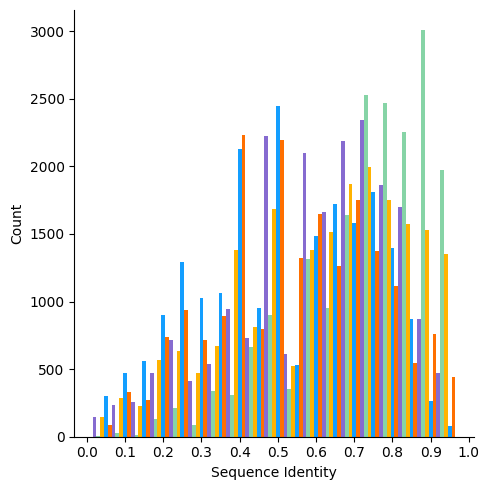

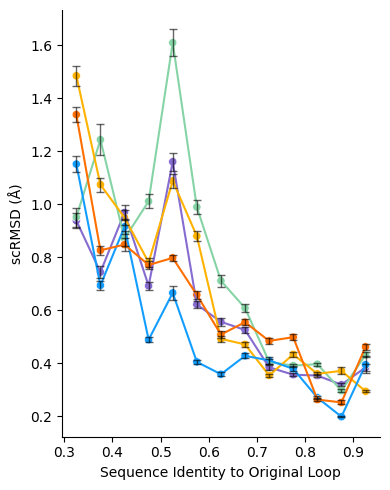

In [19]:
color_palette = {
    'abmpnn': '#866BD0', 
    'antifold': '#86D4A6',
    'igbert_igloo': '#139EFF',
    'proteinmpnn': "#EE136B",
    'igbert': '#FFB300',
    'igloolm': '#FF6F00',
}

plot_df = results_df[results_df['model'] != 'proteinmpnn'].groupby(['model', 'sequence_identity_category'], observed=False).agg(
    mean_rmsd=('rmsd', 'mean'), se_rmsd=('rmsd', 'sem'), std_rmsd=('rmsd', 'std'), count=('rmsd', 'count')
).reset_index()
plot_df['sequence_identity_category'] = plot_df['sequence_identity_category'].astype(float)

plt.figure(figsize=(5,5))
for i, model in enumerate(plot_df['model'].unique()):
    model_data = plot_df[plot_df['model'] == model]
    # Apply horizontal offset if overlapping
    offset = (i - 0.5) * 0.01  # small offset to separate bars slightly
    plt.bar(
        model_data['sequence_identity_category'] + offset,
        model_data['count'],
        width=0.01,
        label=model,
        color=color_palette[model]
    )

# Now the x-axis is truly continuous
plt.xlabel("Sequence Identity")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(0.0, 1.01, 0.1))
plt.legend().remove()
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("figures/sequence_identity_without_protein_mpnn.svg", format='svg', bbox_inches='tight')
plt.show()


plot_df = plot_df[(plot_df['sequence_identity_category'] >= 0.325) & (plot_df['sequence_identity_category'] <= 0.925)] # & (plot_df['count'] > 10)
plt.figure(figsize=(4,5))
sns.scatterplot(
    data=plot_df,
    x='sequence_identity_category',
    y='mean_rmsd',
    hue='model',
    palette=color_palette,
)
sns.lineplot(
    data=plot_df,
    x='sequence_identity_category',
    y='mean_rmsd',
    hue='model',
    palette=color_palette,
)
sns.despine()
for model in plot_df['model'].unique():
    model_data = plot_df[plot_df['model'] == model]
    plt.errorbar(
        x=model_data['sequence_identity_category'].astype(float),
        y=model_data['mean_rmsd'],
        yerr=model_data['se_rmsd'],
        fmt='none',  # no marker
        capsize=3,
        elinewidth=1,
        alpha=0.6,
        color='black',
    )
plt.xlabel("Sequence Identity to Original Loop")
plt.ylabel("scRMSD (Å)")
plt.tight_layout()
plt.legend().remove()
plt.savefig("figures/scRMSD_without_protein_mpnn.svg", format='svg', bbox_inches='tight')
plt.show()

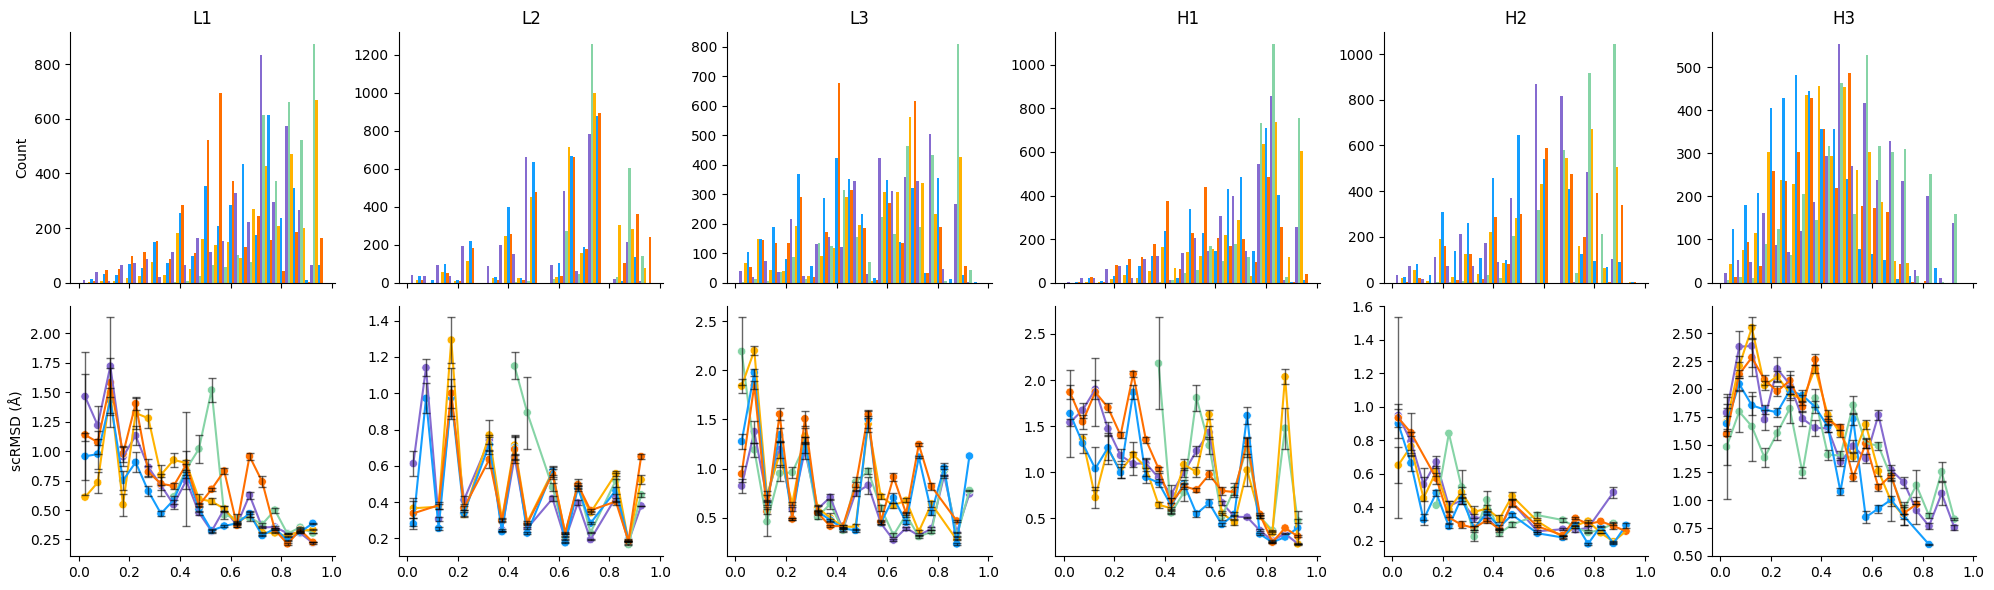

In [17]:
color_palette = {
    'abmpnn': '#866BD0', 
    'antifold': '#86D4A6',
    'igbert_igloo': '#139EFF',
    'proteinmpnn': "#EE136B",
    'igbert': '#FFB300',
    'igloolm': '#FF6F00',
}

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,6), sharex=True)

for loop_i, loop_type in enumerate(['L1', 'L2', 'L3', 'H1', 'H2', 'H3']):
    plot_df = results_df[(results_df['loop_type'] == f'CDR{loop_type[1]}') & (results_df['chain_id'] == loop_type[0]) & (results_df['model'] != 'proteinmpnn')].groupby(['model', 'sequence_identity_category'], observed=False).agg(
        mean_rmsd=('rmsd', 'mean'), se_rmsd=('rmsd', 'sem'), std_rmsd=('rmsd', 'std'), count=('rmsd', 'count')
    ).reset_index()
    plot_df['sequence_identity_category'] = plot_df['sequence_identity_category'].astype(float)
    # plot_df = plot_df[plot_df['count'] > 20]

    for i, model in enumerate(plot_df['model'].unique()):
        model_data = plot_df[plot_df['model'] == model]
        # Apply horizontal offset if overlapping
        offset = (i - 0.5) * 0.01  # small offset to separate bars slightly
        axes[0,loop_i].bar(
            model_data['sequence_identity_category'] + offset,
            model_data['count'],
            width=0.01,
            label=model,
            color=color_palette[model]
        )

    # Now the x-axis is truly continuous
    if loop_i == 0:
        axes[0,loop_i].set_ylabel("Count")
    axes[0,loop_i].set_title(loop_type)
    axes[0,loop_i].set_xticks(ticks=np.arange(0.0, 1.01, 0.2))
    axes[0,loop_i] = plt.gca()
    axes[0,loop_i].spines['top'].set_visible(False)
    axes[0,loop_i].spines['right'].set_visible(False)

    # plot_df = plot_df[(plot_df['sequence_identity_category'] >= 0.325) & (plot_df['sequence_identity_category'] <= 0.925)] # & (plot_df['count'] > 10)
    sns.scatterplot(
        data=plot_df,
        x='sequence_identity_category',
        y='mean_rmsd',
        hue='model',
        palette=color_palette,
        ax=axes[1,loop_i]
    )
    sns.lineplot(
        data=plot_df,
        x='sequence_identity_category',
        y='mean_rmsd',
        hue='model',
        palette=color_palette,
        ax=axes[1,loop_i]
    )
    sns.despine()
    for model in plot_df['model'].unique():
        model_data = plot_df[plot_df['model'] == model]
        axes[1,loop_i].errorbar(
            x=model_data['sequence_identity_category'].astype(float),
            y=model_data['mean_rmsd'],
            yerr=model_data['se_rmsd'],
            fmt='none',  # no marker
            capsize=3,
            elinewidth=1,
            alpha=0.6,
            color='black',
        )
    axes[1,loop_i].get_legend().remove()
    axes[1,loop_i].set_xlabel("")
    axes[1,loop_i].set_ylabel("")
    if loop_i == 0:
        axes[1,loop_i].set_ylabel("scRMSD (Å)")
plt.tight_layout()
plt.savefig("figures/loop_types_without_protein_mpnn.svg", format='svg', bbox_inches='tight')
plt.show()

# Analyse the sequences generated for a particular output

In [61]:
agg_results = results_df[(results_df['model'] == 'igbert_igloo') & (results_df['temperature'] == 0.5)].groupby(['ab_fname', 'loop_type', 'chain_id']).agg(
    rmsd=('rmsd', 'mean'),
    sequence_identity=('sequence_identity', 'mean'),
    edit_distance=('edit_distance', 'mean'),
).reset_index()

for loop_type in ['CDR1', 'CDR2', 'CDR3']:
    for chain_id in ['H', 'L']:
        loop_df = agg_results[(agg_results['loop_type'] == loop_type) & (agg_results['chain_id'] == chain_id) & (agg_results['sequence_identity'] < 0.6)]
        print(f"{loop_type} {chain_id}:")
        display(loop_df.sort_values('rmsd', ascending=True).head(10))

CDR1 H:


,ab_fname,loop_type,chain_id,rmsd,sequence_identity,edit_distance
87,13297_7nx2_BA.pdb,CDR1,H,0.213370,0.553846,5.8
88,13301_7tp4_HL.pdb,CDR1,H,0.227832,0.576923,5.5
46,11712_6d9g_CD.pdb,CDR1,H,0.259728,0.453846,7.1
272,9331_7lfd_HL.pdb,CDR1,H,0.270699,0.392308,7.9
61,121_9iy0_HL.pdb,CDR1,H,0.438011,0.530769,6.1
267,9191_5od0_HL.pdb,CDR1,H,0.510097,0.578571,5.9
101,13889_5ock_HL.pdb,CDR1,H,0.583398,0.557143,6.2
293,9982_5zmj_HL.pdb,CDR1,H,0.623216,0.584615,5.4
31,11154_6mqr_HL.pdb,CDR1,H,0.733462,0.346667,9.8
294,9atm_HL.pdb,CDR1,H,0.948936,0.500000,6.5


CDR1 L:


,ab_fname,loop_type,chain_id,rmsd,sequence_identity,edit_distance
233,7754_6a0x_CD.pdb,CDR1,L,0.192341,0.445455,6.1
188,5135_6cjk_BA.pdb,CDR1,L,0.221119,0.536364,5.1
160,3216_7wg3_EA.pdb,CDR1,L,0.262389,0.520000,4.8
39,11611_5w5z_HL.pdb,CDR1,L,0.265689,0.581818,4.6
162,3218_7wg3_GC.pdb,CDR1,L,0.277939,0.540000,4.6
283,9491_4llw_CD.pdb,CDR1,L,0.283436,0.427273,6.3
84,13130_4ki5_CD.pdb,CDR1,L,0.297741,0.540000,4.6
190,5165_6jwc_HL.pdb,CDR1,L,0.308590,0.550000,5.4
204,5770_2r1w_BA.pdb,CDR1,L,0.321404,0.564706,7.4
3,1017_8acf_HL.pdb,CDR1,L,0.329762,0.440000,8.4


CDR2 H:


,ab_fname,loop_type,chain_id,rmsd,sequence_identity,edit_distance
148,1626_8tfq_HL.pdb,CDR2,H,0.128667,0.588889,3.7
240,7z3a_KP.pdb,CDR2,H,0.153803,0.450000,5.5
213,6626_5xcs_AB.pdb,CDR2,H,0.178300,0.520000,4.8
89,13301_7tp4_HL.pdb,CDR2,H,0.183962,0.490000,5.1
275,934_8hyl_AB.pdb,CDR2,H,0.190121,0.480000,5.2
208,5947_6flb_HL.pdb,CDR2,H,0.202252,0.550000,4.5
158,3176_7r58_HL.pdb,CDR2,H,0.203916,0.440000,5.6
93,13434_6z7z_DC.pdb,CDR2,H,0.217908,0.380000,6.2
217,6823_7tqa_HL.pdb,CDR2,H,0.218939,0.500000,5.0
224,719_8oni_HL.pdb,CDR2,H,0.227308,0.490000,5.1


CDR2 L:


,ab_fname,loop_type,chain_id,rmsd,sequence_identity,edit_distance
249,8612_6xp6_JI.pdb,CDR2,L,0.128817,0.5875,3.3
4,1018_8aci_HL.pdb,CDR2,L,0.129556,0.5500,3.6
8,10462_5u3m_HL.pdb,CDR2,L,0.159274,0.4375,4.5
151,1987_8gbz_HL.pdb,CDR2,L,0.159985,0.4875,4.1
257,8uig_HL.pdb,CDR2,L,0.161811,0.5375,3.7
273,9348_6o9h_HL.pdb,CDR2,L,0.168332,0.4375,4.5
133,14853_5grv_LK.pdb,CDR2,L,0.174952,0.4750,4.2
171,4047_2fb4_HL.pdb,CDR2,L,0.175287,0.5375,3.7
195,5307_1ay1_HL.pdb,CDR2,L,0.184485,0.1875,6.5
73,12648_4jam_AB.pdb,CDR2,L,0.194251,0.3750,5.0


CDR3 H:


,ab_fname,loop_type,chain_id,rmsd,sequence_identity,edit_distance
54,12048_5d7s_HL.pdb,CDR3,H,0.507034,0.462500,4.3
53,12024_3mnz_BA.pdb,CDR3,H,0.617661,0.133333,5.2
47,11744_1ct8_BA.pdb,CDR3,H,0.623595,0.336364,7.3
16,10856_1t66_HL.pdb,CDR3,H,0.674858,0.344444,5.9
167,3709_7tcq_AB.pdb,CDR3,H,0.793783,0.266667,6.6
185,4939_6yla_HL.pdb,CDR3,H,0.883746,0.525000,5.7
215,6711_1aj7_HL.pdb,CDR3,H,0.928719,0.100000,6.3
226,7272_7uen_HL.pdb,CDR3,H,0.944144,0.188889,7.3
25,11028_7lop_BC.pdb,CDR3,H,0.983831,0.466667,6.4
111,14121_6wg1_AB.pdb,CDR3,H,1.088808,0.275000,8.7


CDR3 L:


,ab_fname,loop_type,chain_id,rmsd,sequence_identity,edit_distance
209,598_8vvb_AB.pdb,CDR3,L,0.224338,0.380000,3.1
245,8372_4ebq_HL.pdb,CDR3,L,0.224544,0.400000,5.4
285,9547_5csz_AB.pdb,CDR3,L,0.246983,0.322222,6.1
82,12956_5dr5_HL.pdb,CDR3,L,0.255008,0.422222,5.2
55,12087_1nlb_HL.pdb,CDR3,L,0.305201,0.522222,4.3
20,10927_1il1_AB.pdb,CDR3,L,0.311934,0.550000,3.6
40,11611_5w5z_HL.pdb,CDR3,L,0.317336,0.350000,5.2
230,7493_2ck0_HL.pdb,CDR3,L,0.320734,0.412500,4.7
76,12732_7t0k_DC.pdb,CDR3,L,0.336777,0.462500,4.3
9,10501_2g5b_BA.pdb,CDR3,L,0.338510,0.287500,5.7


In [109]:
loop_type = 'CDR3'
chain_id = 'L'
ab_fname = '8372_4ebq_HL.pdb'

In [ ]:
chain_df = pd.read_parquet("preprocessed_data/sabdab_2025-05-06-paired_chains.parquet")
chain_df[(chain_df['ab_fname'] == ab_fname) & (chain_df['chain_id'] == chain_id)].iloc[0]

sabdab_id                                                  7902
ab_fname                                       8372_4ebq_HL.pdb
chain_id                                                      L
FW1_start                                                     0
FW1_end                                                      23
CDR1_start                                                   23
CDR1_end                                                     33
FW2_start                                                    33
FW2_end                                                      47
CDR2_start                                                   47
CDR2_end                                                     55
FW3_start                                                    55
FW3_end                                                      64
CDR4_start                                                   64
CDR4_end                                                     70
FW4_start                               

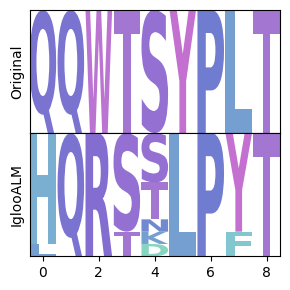

In [111]:
import logomaker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

# Define base colors for the gradient
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", ['#86D4A6', '#86D4C7', '#80C0D3', '#769FD1', '#769FD1', '#6E7DD0', '#866BD0', '#AD7AD3', '#C470D0']
)

# Get 20 colors from the gradient
colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, 20)]

# Create color scheme dictionary
color_scheme = dict(zip(amino_acids, colors))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3, 3))

sequences_to_plot = results_df[(results_df['ab_fname'] == ab_fname) & (results_df['model'] == 'igbert_igloo') & (results_df['loop_type'] == loop_type) & (results_df['chain_id'] == chain_id) & (results_df['temperature'] == 0.5)]
counts_mat = logomaker.alignment_to_matrix(sequences=sequences_to_plot['sabdab_seq'], to_type='counts')
logo = logomaker.Logo(counts_mat, color_scheme=color_scheme, ax=axes[0])
counts_mat = logomaker.alignment_to_matrix(sequences=sequences_to_plot['sampled_seq'], to_type='counts')
logo = logomaker.Logo(counts_mat, color_scheme=color_scheme, ax=axes[1])
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xticks(np.arange(0, len(sequences_to_plot['sabdab_seq'].iloc[0]), 2))
axes[0].set_ylabel('Original')
axes[1].set_ylabel('IglooALM')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(f"figures/{ab_fname}_{chain_id}{loop_type}_sequence_logo.svg", format='svg', bbox_inches='tight')
plt.show()

In [112]:
print(f"{ab_fname} {chain_id} {loop_type}")
print(f"Edit distance: {sequences_to_plot['edit_distance'].mean():.2f}")
print(f"Sequence identity: {sequences_to_plot['sequence_identity'].mean():.2f}")
print(f"Loop scRMSD: {sequences_to_plot['rmsd'].mean():.2f}")

8372_4ebq_HL.pdb L CDR3
Edit distance: 5.40
Sequence identity: 0.40
Loop scRMSD: 0.22
